This project aims to predict the yearly temperature change of a given city over a given time period, using an SARIMA model for time series forecasting.

I used data from the <i><a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data" target="_blank">Climate Change: Earth Surface Temperature Data</a></i> dataset on Kaggle. In particular MajorCities Dataset.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
cities = pd.read_csv('city.csv')

In [4]:
cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [5]:
cities.shape

(239177, 7)

In [10]:
ind=cities.loc[cities['Country'] == 'India']

In [11]:
ind.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
3942,1796-01-01,19.649,2.286,Ahmadabad,India,23.31N,72.52E
3943,1796-02-01,21.632,1.770,Ahmadabad,India,23.31N,72.52E
3944,1796-03-01,24.953,2.427,Ahmadabad,India,23.31N,72.52E
3945,1796-04-01,30.297,1.827,Ahmadabad,India,23.31N,72.52E
3946,1796-05-01,33.223,1.496,Ahmadabad,India,23.31N,72.52E


In [12]:
ind.City.unique()

array(['Ahmadabad', 'Bangalore', 'Bombay', 'Calcutta', 'Delhi',
       'Hyderabad', 'Jaipur', 'Kanpur', 'Lakhnau', 'Madras', 'Nagpur',
       'New Delhi', 'Pune', 'Surat'], dtype=object)

In [25]:
hyd=ind.loc[ind['City'] == 'Hyderabad',['dt','AverageTemperature']]

In [26]:
hyd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2613 entries, 85749 to 88361
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dt                  2613 non-null   object 
 1   AverageTemperature  2508 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.2+ KB


In [27]:
hyd.columns = ['Date','Temp']
hyd['Date'] = pd.to_datetime(hyd['Date'])

In [28]:
hyd

,Date,Temp
85749,1796-01-01,22.759
85750,1796-02-01,25.094
85751,1796-03-01,27.725
85752,1796-04-01,31.280
85753,1796-05-01,32.701
...,...,...
88357,2013-05-01,34.650
88358,2013-06-01,29.487
88359,2013-07-01,27.011
88360,2013-08-01,26.923


In [29]:
hyd.set_index('Date', inplace=True)

In [30]:
hyd

,Temp
Date,
1796-01-01,22.759
1796-02-01,25.094
1796-03-01,27.725
1796-04-01,31.280
1796-05-01,32.701
...,...
2013-05-01,34.650
2013-06-01,29.487
2013-07-01,27.011


In [31]:
delhi = delhi.dropna()

In [32]:
delhi

,Temp
Date,
1796-01-01,14.590
1796-02-01,17.109
1796-03-01,21.454
1796-04-01,28.715
1796-05-01,33.726
...,...
2013-04-01,29.304
2013-05-01,34.746
2013-06-01,33.066


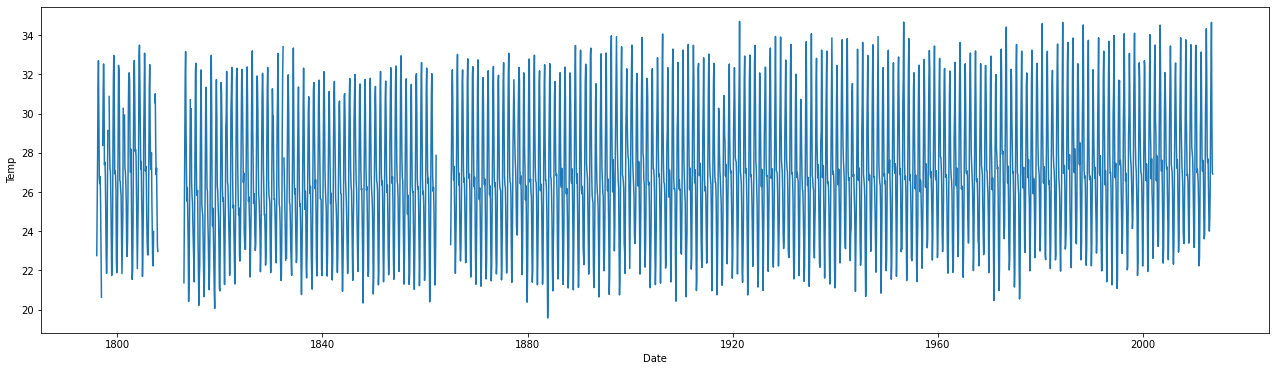

In [38]:
plt.figure(figsize=(22,6))
sns.lineplot(x=hyd.index, y=hyd['Temp'])
plt.show()

In [58]:
hyd = hyd.loc['1900':'2013-01-01']
hyd = hyd.asfreq('M', method='bfill')

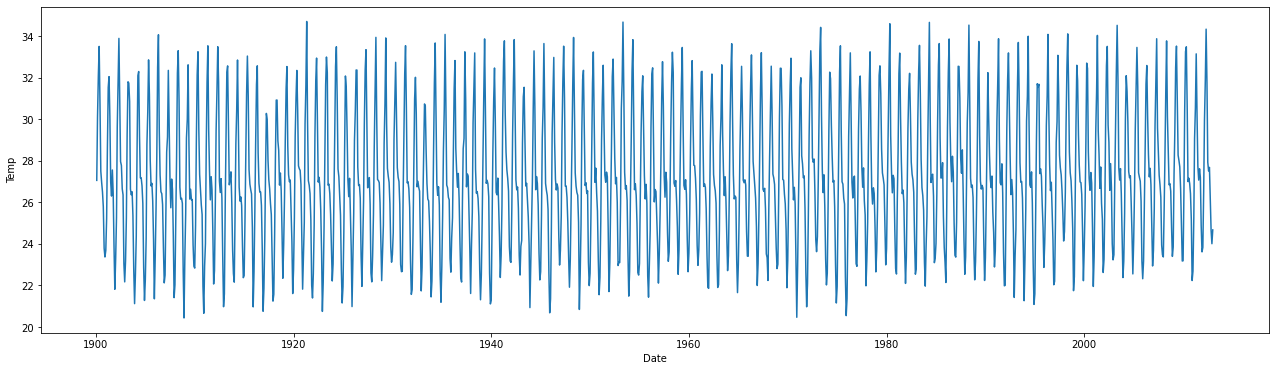

In [59]:
plt.figure(figsize=(22,6))
sns.lineplot(x=hyd.index, y=hyd['Temp'])
plt.show()

In [60]:
hyd['month'] = hyd.index.month
hyd['year'] = hyd.index.year

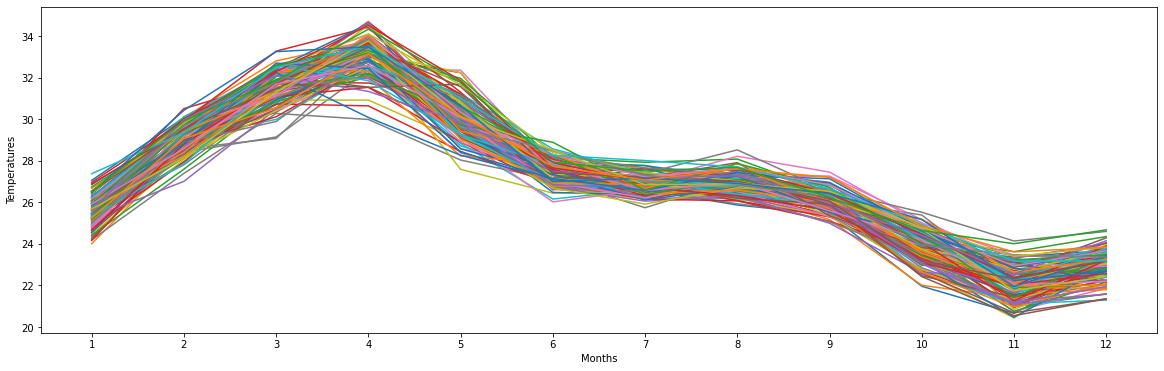

In [61]:
pivot = pd.pivot_table(hyd, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

The series clearly has some seasonality, the higher temperatures are around April and the lower are in November. Just to make the things clear, I'll merge these lines into just one line, averaging the monthly levels:

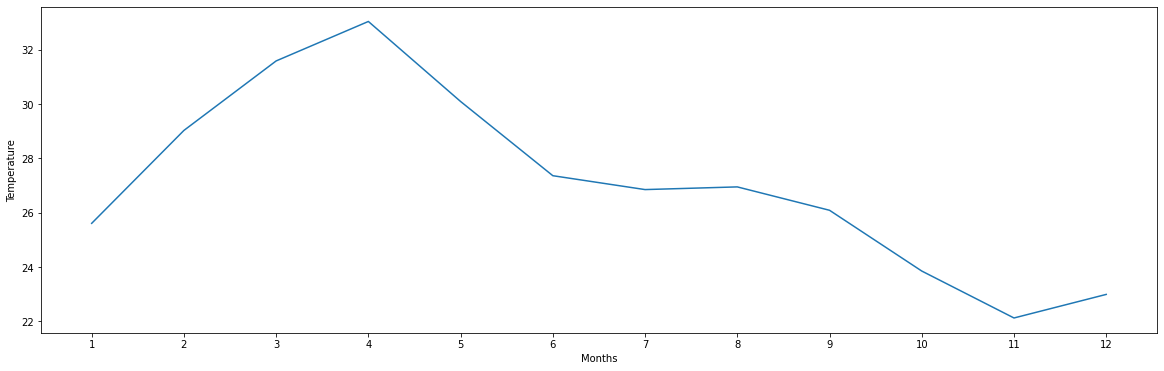

In [62]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

Now i'm going to check if there is some trend through the years in this Series:

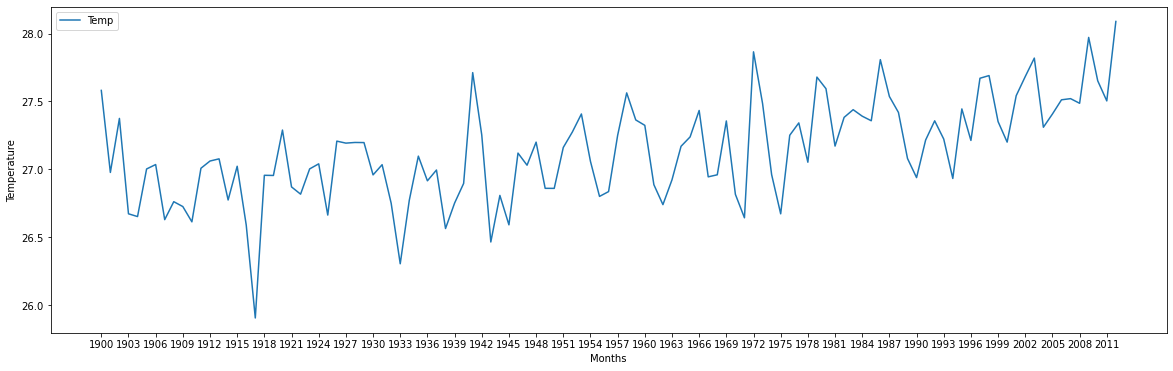

In [63]:
year_avg = pd.pivot_table(hyd, values='Temp', index='year', aggfunc='mean')
year_avg.plot(figsize=(20,6))
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

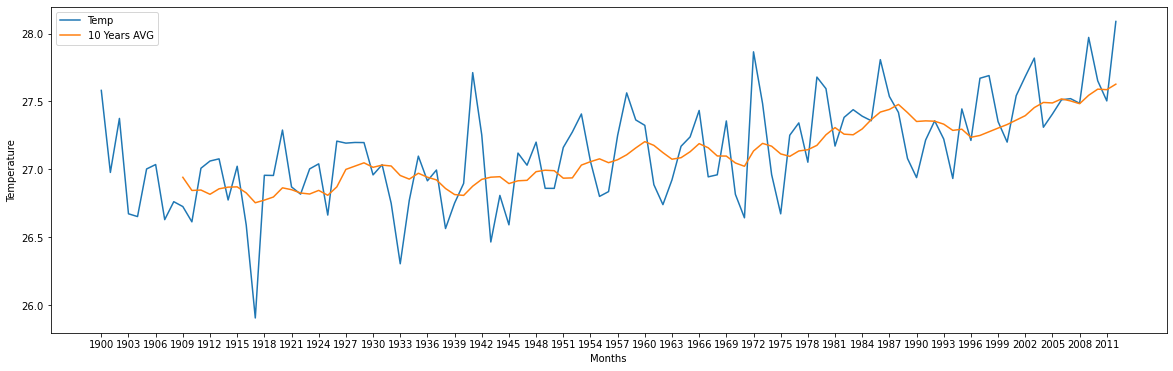

In [64]:
year_avg['10 Years AVG'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years AVG']].plot(figsize=(20,6))
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

We can confirm that there is a constant increasing trend and that the average temperature increased from 27º to 27.5º, that's 1.85% in over 100 years.

Before we go on, i'm going to split the data in training, validation and test set. After training the model, I will use the last 5 years to do the data validation and test, being 48 months to do a month by month validation and 12 months to make an extrapolation for the future and compare to the test set

In [66]:
train = hyd[:-60].copy()
val = hyd[-60:-12].copy()
test = hyd[-12:].copy()

In [74]:
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29    25.670
2008-03-31    28.150
2008-04-30    31.309
2008-05-31    33.765
2008-06-30    30.131
Freq: M, Name: Temp, dtype: float64

In [75]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

In [76]:
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 2.1332 celsius degrees


As we can see, the series has a small uptrend and it appears that there is some seasonality with higher temperatures at the begining and end of the year and lower temperatures around the end of the year.

To create a time series forecast, the series must be stationary (constant mean, variance and autocorrelation)
One way to check if the series is stationary is using the adfuller function, if the P-Value is lower than 5% (usual number used for this kind of study) the series is stationary and you can start creating your model.

If the series isn't stationary you can do some data transformation like using natural logarithm, deflation, differencing, etc.

Below is the function that I used to check the stationarity, it plots:

The series itself;

The autocorrelation function (ACF):
It shows the correlation between the current temperatures versus the lagged versions of itself.

The partial autocorrelation (PACF):
It shows the correlation between the current temperatures versus the lagged version excluding the effects of earlier lags, for example, it show the effective influence of the lag 3 in the current temperatures excluding the effects of the lags 1 and 2.

In [79]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
   
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -4.0071
p-value                           0.0014
Lags Used                        23.0000
Number of Observations Used    1272.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


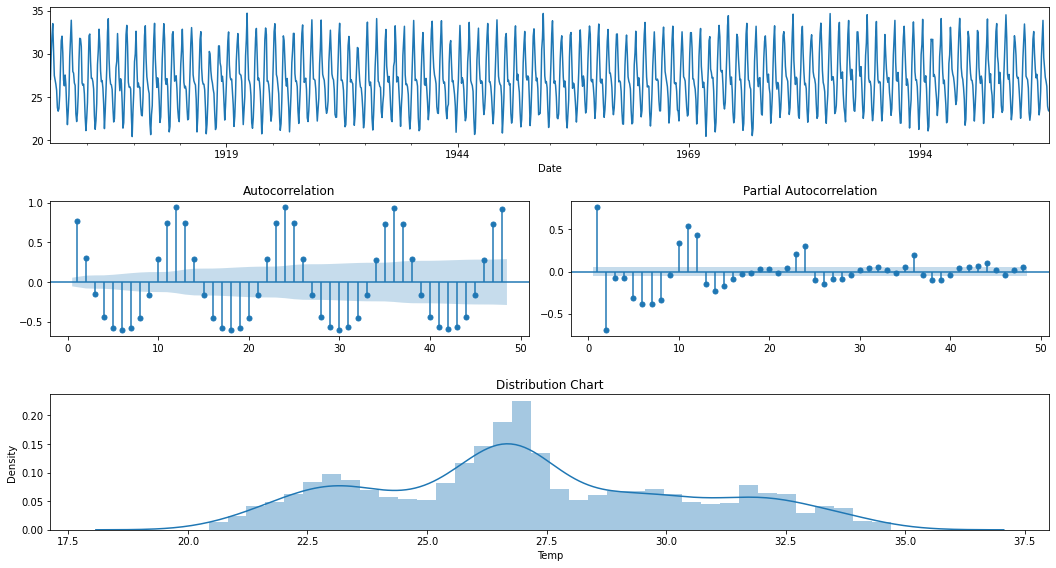

In [80]:
check_stationarity(train['Temp'])

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 2 and repeating each 12 months, it's because of the difference in the seasons, if today is winter with cold temperatures in 6 months we will have higher temperatures in the summer, that's why the negative autocorrelation occurs. These temperatures usually walk in opposite directions.

Also, from lag 12 and sequentially from every 12 lags there is a significant positive autocorrelation. 

This behavior between the **ACF** and **PACF** plots suggests an AR(1) model and also a first seasonal difference ($Y_{t} - Y_{t-12}$). I'll plot the stationarity function again with the first seasonal difference to see if we will need some SAR(P) or SMA(Q) parameter:

Results of Dickey-Fuller Test:
Test Statistic                  -12.2861
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1260.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


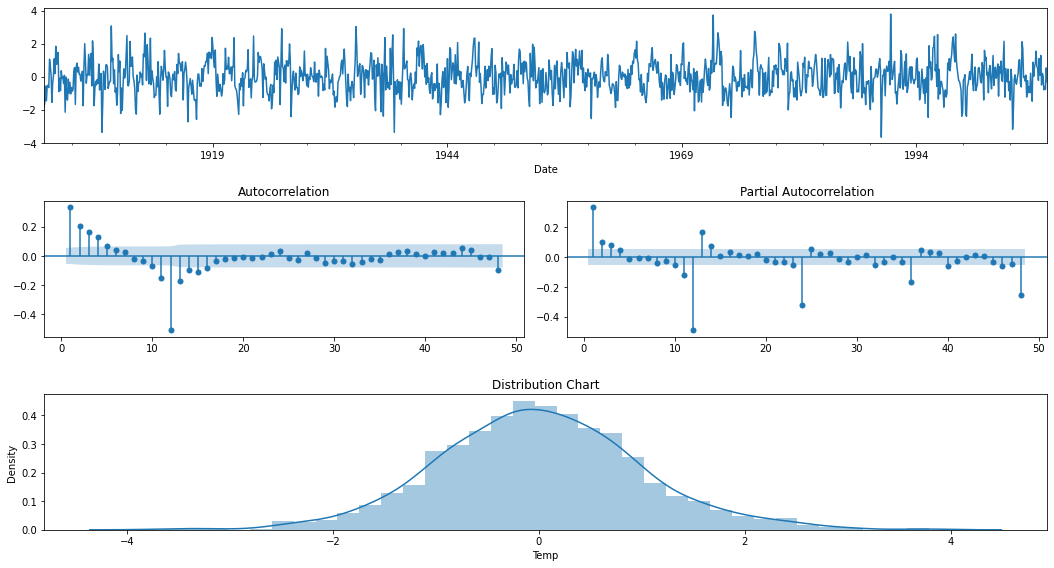

In [81]:
check_stationarity(train['Temp'].diff(12).dropna())

As the plots above showed, the first **ACF** lags have a gradual decay, while the **PACF** drops under the confidence interval after the fourth lag, this is an **AR** signature with a parameter of 4, so this is an **AR(4)** model.

As we used a first seasonal difference, the **ACF** and **PACF** showed a significative drop in the 12th lag, it means an **SMA** signature with a parameter of 1 lag, resuming this is an **SAR(1) with a first difference**.

Initially i'm going to work with the following (p,d,q) orders: (3, 0, 0), and with the following seasonal (P, D, Q, S) orders (0,1,1,12) and as the series has a clear uptrend i'm going to use it in the model ('c'). 
 
To start forecasting the validation set, I'm going to create a function to use one-step-forecast in the whole validation set and measure the error:

In [85]:
def walk_forward(training_set, validation_set, params):
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [86]:
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [87]:
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.576 celsius degrees
It's a decrease of -73.0% in the RMSE


In [88]:
val['Error'] = val['Temp'] - val['Pred']

In [90]:
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,25.670,26.055516,-0.385516
2008-02-29,28.150,29.365301,-1.215301
2008-03-31,31.309,31.532099,-0.223099
2008-04-30,33.765,32.994354,0.770646
2008-05-31,30.131,30.327671,-0.196671


In [89]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

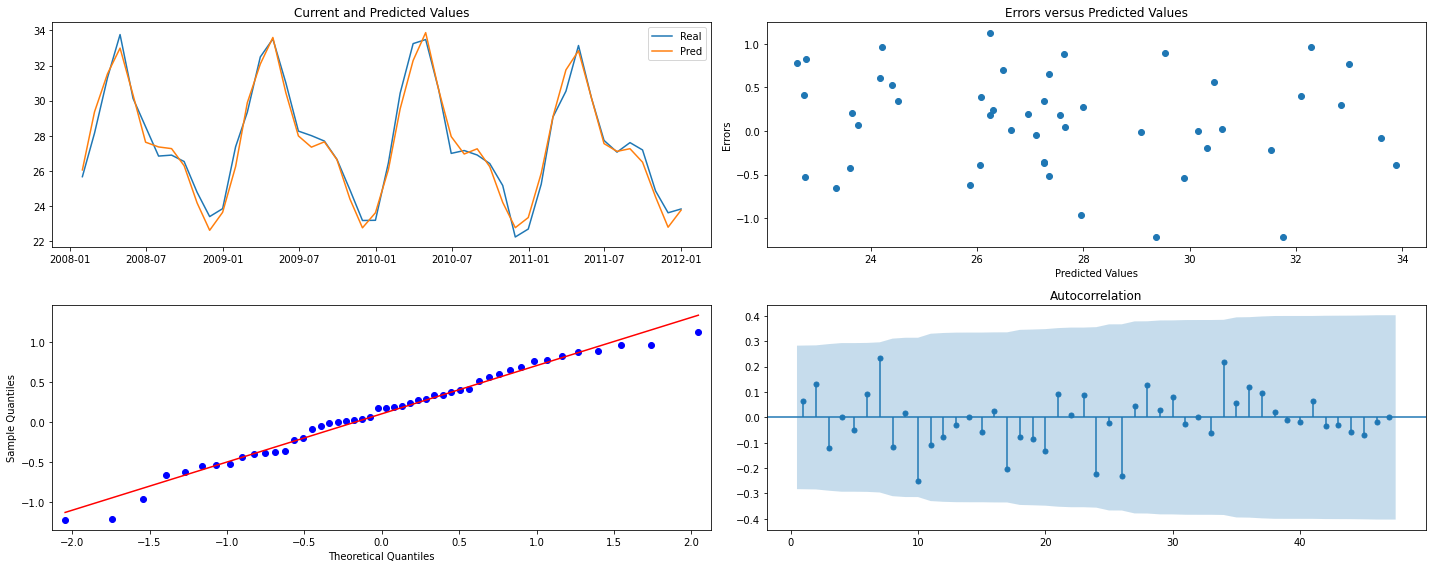

In [91]:
plot_error(val)

Analyzing the plots above we can see that the predictions fit very well on the current values.

The **Error vs Predicted values** has a linear distribution (the errors are between -1 and +1 while the temperature increases).

The QQ Plot shows a normal pattern with some little outliers and,

The autocorrelation plot is well in the confidence interval and no need for more changes.

Finally it's time to extrapolate the prediction in the **test set** for the last 12 months

In [92]:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31    27.054
1900-02-28    30.078
1900-03-31    32.087
1900-04-30    33.500
1900-05-31    30.685
Freq: M, Name: Temp, dtype: float64

In [93]:
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [94]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

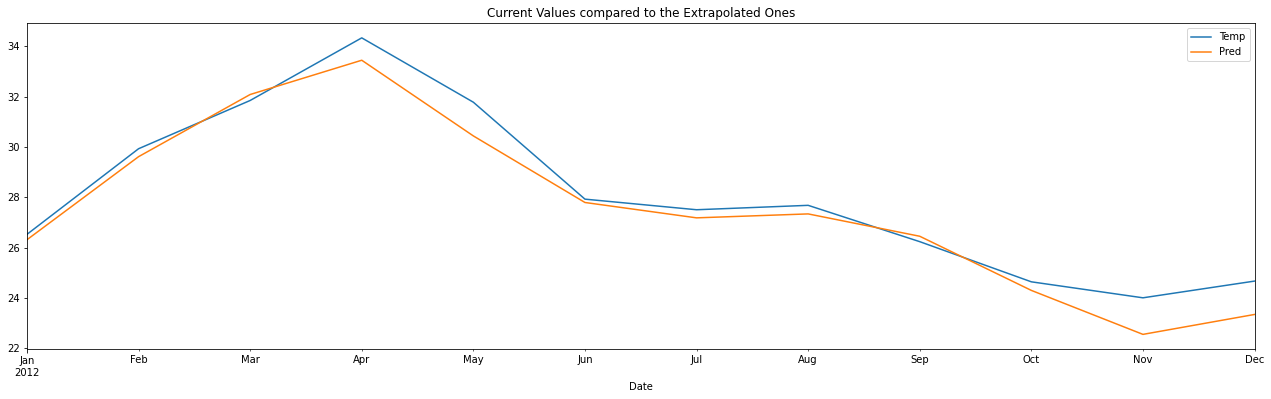

In [95]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

It seems that the SARIMA parameters were well fitted, the predicted values are following the real values and also the seasonal pattern.

Finally I'll evaluate the model with the RMSE in the test set (baseline against the extrapolation):

In [96]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 2.01 celsius degrees
The baseline RMSE for the test extrapolation was 0.77 celsius degrees
That is an improvement of 61.86%
